## Device configuration

In [1]:
import torch

if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")  
print(device)

mps


## Model

In [2]:
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Conv2d(1, 32, kernel_size=(3,3))
        self.l2 = nn.Conv2d(32, 64, kernel_size=(3,3))
        self.l3 = nn.Linear(1600, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.l1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.l2(x)), (2,2))
        return self.l3(F.dropout(x.flatten(1), 0.5, self.training))

## Get the MNIST dataset

In [3]:
from tinygrad.nn.datasets import mnist

X_train, Y_train, X_test, Y_test = mnist()

# Convert tinygrad Tensors to PyTorch tensors 
X_train = torch.from_numpy(X_train.numpy()).float().reshape(-1, 1, 28, 28).to(device)
Y_train = torch.from_numpy(Y_train.numpy()).long().to(device)
X_test = torch.from_numpy(X_test.numpy()).float().reshape(-1, 1, 28, 28).to(device) 
Y_test = torch.from_numpy(Y_test.numpy()).long().to(device)

print(X_train.shape, X_train.dtype, Y_train.shape, Y_train.dtype)

torch.Size([60000, 1, 28, 28]) torch.float32 torch.Size([60000]) torch.int64


## Use the model

In [4]:
model = Model().to(device)
acc = (model(X_test).argmax(axis=1) == Y_test).float().mean()
print(acc.item())  

0.09510000050067902


In [5]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}\n")
    return total_params

count_parameters(model)

+-----------+------------+
|  Modules  | Parameters |
+-----------+------------+
| l1.weight |    288     |
|  l1.bias  |     32     |
| l2.weight |   18432    |
|  l2.bias  |     64     |
| l3.weight |   16000    |
|  l3.bias  |     10     |
+-----------+------------+
Total Trainable Params: 34826



34826

### Train the model

In [6]:
optim = torch.optim.Adam(model.parameters())
batch_size = 128
def training_step():
    model.train()  # enables dropout
    samples = torch.randint(high=X_train.shape[0], size=(batch_size,))
    X, Y = X_train[samples], Y_train[samples]
    optim.zero_grad()
    loss = F.nll_loss(F.log_softmax(model(X), dim=1), Y)
    loss.backward()
    optim.step()
    return loss

In [7]:
# import timeit
# execution_times_5ts = [t * 1000 for t in timeit.repeat(training_step, repeat=5, number=1)]
# average_time_ts = sum(execution_times_5ts) / len(execution_times_5ts)
# print(f"Average execution time: {average_time_ts:.2f} ms")

In [8]:
train_losses = []
test_losses = []

train_accuracies = []
test_accuracies = []

for step in range(7000):
    # Calculate train loss
    loss = training_step()  
    train_losses.append(loss.item())
    
    if step % 100 == 0:
        model.eval()  # Disables dropout for evaluation
        
        with torch.no_grad():
            # Calculate train accuracy
            # train_outputs = model(X_train)
            # train_acc = (train_outputs.argmax(dim=1) == Y_train).float().mean().item()
            # train_accuracies.append(train_acc)

            # Calculate test accuracy
            test_outputs = model(X_test)
            test_acc = (test_outputs.argmax(dim=1) == Y_test).float().mean().item()
            test_accuracies.append(test_acc)

            # Calculate test loss
            test_loss = F.nll_loss(F.log_softmax(model(X_test), dim=1), Y_test).item()
            test_losses.append(test_loss)

        # print(f"step {step:4d}, loss {loss.item():.2f}, train acc {train_acc*100.:.2f}%, test acc {test_acc*100.:.2f}%")
        print(f"step {step:4d}, loss {loss.item():.2f}, test acc {test_acc*100.:.2f}%")
        model.train()  # Re-enables dropout for training

step    0, loss 38.40, test acc 9.23%
step  100, loss 0.39, test acc 94.76%
step  200, loss 0.28, test acc 96.35%
step  300, loss 0.12, test acc 96.86%
step  400, loss 0.27, test acc 97.42%
step  500, loss 0.28, test acc 96.89%
step  600, loss 0.23, test acc 97.60%
step  700, loss 0.26, test acc 97.51%
step  800, loss 0.26, test acc 97.66%
step  900, loss 0.18, test acc 97.81%
step 1000, loss 0.13, test acc 97.92%
step 1100, loss 0.12, test acc 97.68%
step 1200, loss 0.26, test acc 98.04%
step 1300, loss 0.07, test acc 98.10%
step 1400, loss 0.06, test acc 98.20%
step 1500, loss 0.07, test acc 98.41%
step 1600, loss 0.24, test acc 98.06%
step 1700, loss 0.12, test acc 98.27%
step 1800, loss 0.04, test acc 97.97%
step 1900, loss 0.17, test acc 97.90%
step 2000, loss 0.19, test acc 98.03%
step 2100, loss 0.08, test acc 98.51%
step 2200, loss 0.15, test acc 98.43%
step 2300, loss 0.36, test acc 98.19%
step 2400, loss 0.11, test acc 98.43%
step 2500, loss 0.07, test acc 98.25%
step 2600, l

Average PyTorch runtime (No Train Acc): 30.48 ms
Average Tinygrad runtime: 74.20 ms


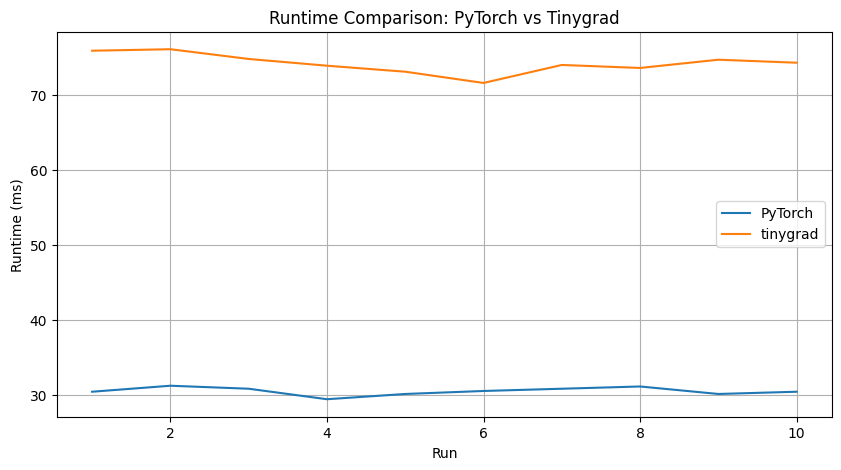

In [18]:
pytorch_runtimes_no_trainacc = [30.4, 31.2, 30.8, 29.4, 30.1, 30.5, 30.8, 31.1, 30.1, 30.4]
tinygrad_runtimes = [75.9, 76.1, 74.8, 73.9, 73.1, 71.6, 74.0, 73.6, 74.7, 74.3]
# pytorch_runtimes_yes_trainacc = [44.3, 43.6, 42.0, 44.1, 43.8, 44.2]

avg_pytorch_no_trainacc = sum(pytorch_runtimes_no_trainacc) / len(pytorch_runtimes_no_trainacc)
avg_tinygrad = sum(tinygrad_runtimes) / len(tinygrad_runtimes)
# avg_pytorch_yes_trainacc = sum(pytorch_runtimes_yes_trainacc) / len(pytorch_runtimes_yes_trainacc)

print(f"Average PyTorch runtime (No Train Acc): {avg_pytorch_no_trainacc:.2f} ms")
print(f"Average Tinygrad runtime: {avg_tinygrad:.2f} ms")
# print(f"Average PyTorch runtime (With Train Acc): {avg_pytorch_yes_trainacc:.2f} ms")

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(pytorch_runtimes_no_trainacc) + 1), pytorch_runtimes_no_trainacc, label='PyTorch')
plt.plot(range(1, len(tinygrad_runtimes) + 1), tinygrad_runtimes, label='tinygrad')
plt.title('Runtime Comparison: PyTorch vs Tinygrad')
plt.xlabel('Run')
plt.ylabel('Runtime (ms)')
plt.legend()
plt.grid(True)
plt.show()

### Plot the loss

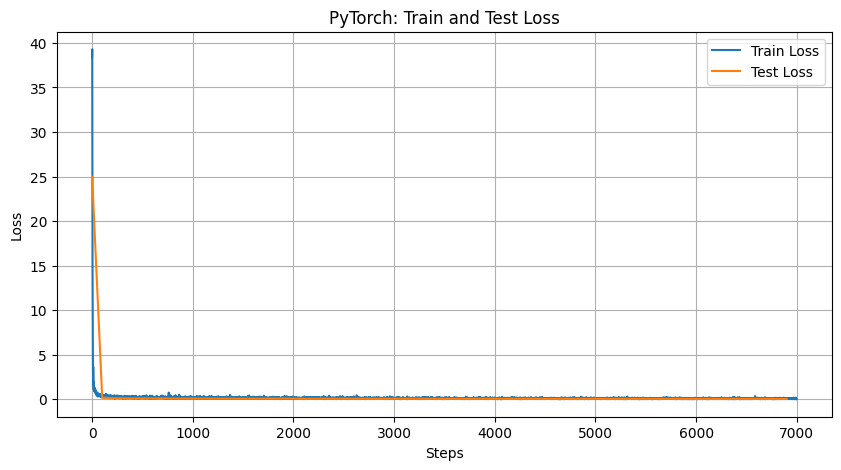

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(len(train_losses)), train_losses, label='Train Loss')
plt.plot(range(0, len(test_losses) * 100, 100), test_losses, label='Test Loss') # every 100 steps
plt.title('PyTorch: Train and Test Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Plot the accuracy 

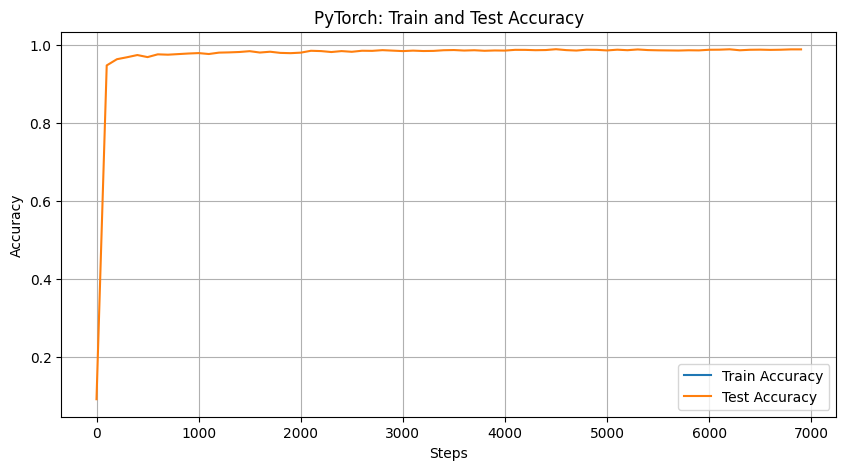

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(range(0, len(train_accuracies) * 100, 100), train_accuracies, label='Train Accuracy')
plt.plot(range(0, len(test_accuracies) * 100, 100), test_accuracies, label='Test Accuracy')
plt.title('PyTorch: Train and Test Accuracy')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### Save the weights

In [12]:
import numpy as np

# Save PyTorch model weights in .npy format
pytorch_weights = {
    'l1.weight': model.l1.weight.detach().cpu().numpy(),
    'l1.bias': model.l1.bias.detach().cpu().numpy(),
    'l2.weight': model.l2.weight.detach().cpu().numpy(),
    'l2.bias': model.l2.bias.detach().cpu().numpy(),
    'l3.weight': model.l3.weight.detach().cpu().numpy(),
    'l3.bias': model.l3.bias.detach().cpu().numpy()
}
np.save('pytorch_weights.npy', pytorch_weights)

## Final probabilities

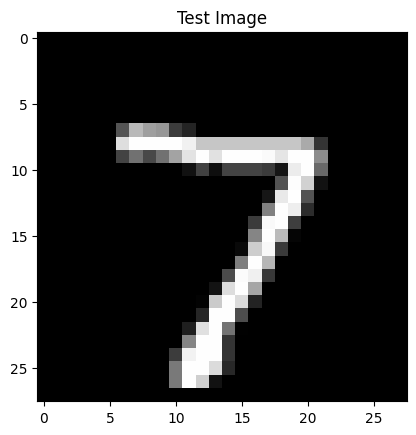

In [13]:
import matplotlib.pyplot as plt

# Select the test image
test_image = X_test[0:1]

# Plot the image
plt.imshow(test_image.cpu().squeeze(), cmap='gray')
plt.title("Test Image")
plt.show()

In [14]:
test_image = X_test[0:1]
model.eval()
with torch.no_grad():
    pytorch_probs = F.softmax(model(test_image), dim=1).cpu().numpy()
print("PyTorch probabilities:", pytorch_probs)

PyTorch probabilities: [[2.5217993e-11 2.8312767e-11 5.4703495e-08 3.4857233e-09 3.6309423e-14
  2.0481152e-13 9.7868301e-20 1.0000000e+00 1.6638195e-10 2.3181967e-08]]


## Export to ONNX format

In [15]:
# import torch.onnx

# dummy_input = torch.randn(1, 1, 28, 28)
# torch.onnx.export(model, 
#                   dummy_input, 
#                   "mnist_model.onnx")